In [1]:
import numpy as np
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
from Scripts.DataManager.GraphLoader.AGGraphDataModule import AGGraphDataModule
import time
import torch
import torch_geometric

config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
# config = Config(r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence2\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding2 import HeteroDeepGraphEmbedding2
from Scripts.Models.LightningModels.LightningModels import HeteroBinaryLightningModel, MultiClassLightningModel, HeteroMultiClassLightningModel
from Scripts.Models.LossFunctions.HeteroLossFunctions import HeteroLossArgs, HeteroLoss1, HeteroLoss2, MulticlassHeteroLoss1
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [3]:

graph_type = TextGraphType.SENTIMENT
# removals = ['sentiment'] # Enter node types to remove here
# removals = ['general'] # Without General Nodes
# removals = ['dep'] # Without Dependency Nodes
# removals = ['tag'] # Without Tag Nodes
# removals = ['sentiment'] # Without Sentiment Nodes
# removals = ['sentiment' , 'general'] # Without Sentiment and General Nodes
data_manager = AGGraphDataModule(config, True, True, test_size=0.055, val_size=0.055, shuffle=False, start_data_load=0 , end_data_load = 127000 , device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AG\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 127/127 [14:16<00:00,  6.75s/it]


In [4]:
# del os.environ['CUDA_LAUNCH_BLOCKING']

In [5]:
# for data in data_manager.dataset[TextGraphType.SENTIMENT]:
#     data[0].to('cuda')
#     data[1].to('cuda')

In [6]:
# # data_manager.update_batch_size(128)
# t_dataloader = data_manager.train_dataloader()
# v_dataloader = data_manager.val_dataloader()
# X1, y1 = next(iter(t_dataloader))
# X2, y2 = next(iter(v_dataloader))

In [7]:
test_dataloader = data_manager.test_dataloader()
X3, Y3 = next(iter(test_dataloader))

In [8]:
X3.metadata()

(['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word'),
  ('word', 'word_sentiment', 'sentiment'),
  ('sentiment', 'sentiment_word', 'word')])

In [152]:


import torch.nn.functional as F
from torch import Tensor
import torch
from torch.nn import Linear
from torch_geometric.nn import BatchNorm, MemPooling, to_hetero, PairNorm
from torch_geometric.data import HeteroData
from Scripts.Models.BaseModels.HeteroGat import HeteroGat
from Scripts.Models.BaseModels.HeteroLinear import HeteroLinear


class HeteroDeepGraphEmbedding5(torch.nn.Module):
    
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 hidden_feature: int=256,
                 device = 'cpu',
                 dropout=0.1,
                 edge_type_count=9,
                 edge_type_weights=-1,
                 active_keys = ['dep', 'tag', 'word', 'sentence', 'general', 'sentiment']
                 ):

        super(HeteroDeepGraphEmbedding5, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.hidden_feature: int = hidden_feature
        self.edge_type_count = edge_type_count
        self.edge_type_weights = [1]* self.edge_type_count if edge_type_weights==-1 else edge_type_weights

        self.part_weight_norm = torch.nn.LayerNorm((self.edge_type_count,))
        self.norm = PairNorm()
        self.drop = torch.nn.Dropout(0.2)
        self.active_keys = active_keys
        
        self.hetero_gat_1 = to_hetero(HeteroGat(input_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        self.hetero_gat_2 = to_hetero(HeteroGat(self.hidden_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        
        self.hetero_linear_2 = to_hetero(HeteroLinear(self.hidden_feature, self.hidden_feature, dropout, use_batch_norm=True), metadata)
        
        num_classes = self.num_out_features
        self.mem_pool = MemPooling(self.hidden_feature, self.hidden_feature, 2, num_classes)
        self.linear_1 = Linear(self.hidden_feature* num_classes, self.hidden_feature)
        self.linear_2 = Linear(self.hidden_feature, self.hidden_feature)
        self.batch_norm_1 = BatchNorm(self.hidden_feature)
        self.output_layer = Linear(self.hidden_feature, self.num_out_features)
        self.dep_embedding = torch.nn.Embedding(45, self.input_features)
        self.tag_embedding = torch.nn.Embedding(50, self.input_features)
        self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
        self.model_logger = [0] * 11
        self.norm_logger = [0] * 8
        self.x_batches = None
        self.x_batches_cpu = None
        self.x_dict_cpu_1 = None
        self.x_dict_cpu_2 = None
        

    def forward(self, x: HeteroData) -> Tensor:
        self.x_batches = {k:x[k].batch for k in self.active_keys}
        self.x_batches_cpu = {k:self.x_batches[k].to('cpu') for k in self.active_keys}
        x_dict, edge_attr_dict, edge_index_dict = self.preprocess_data(x)
        edge_attr_dict = self.update_weights(edge_attr_dict, self.pw1)
        
        x_dict = self.hetero_gat_1(x_dict, edge_index_dict, edge_attr_dict)
        self.x_dict_cpu_1 = {k: x_dict[k].to('cpu') for k in x_dict}
        self.normalize(x_dict, self.x_batches)
        x_dict = self.hetero_gat_2(x_dict, edge_index_dict, edge_attr_dict)
        self.x_dict_cpu_2 = {k: x_dict[k].to('cpu') for k in x_dict}
        x_pooled, S = self.mem_pool(x_dict['word'], self.x_batches['word'])
                
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        x_pooled = F.relu(self.linear_1(x_pooled))
        x_pooled = F.relu(self.batch_norm_1(self.linear_2(x_pooled)))
        out = self.output_layer(x_pooled)
        return out, x_dict

    def preprocess_data(self, x):
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        if 'dep' in x_dict:
            x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        if 'tag' in x_dict:
            x_dict['tag'] = self.tag_embedding(x_dict['tag'])

        edge_attr_dict = x.edge_attr_dict
        edge_index_dict = x.edge_index_dict

        return x_dict, edge_attr_dict, edge_index_dict

    def normalize(self, x_dict, x_batches):
        for k in self.active_keys:
            vecs = x_dict[k]
            if k not in x_batches:
                print('k is not in x_batches')
                continue
            batches = x_batches[k]
            if batches is None:
                print('batches is none')
                continue
            
            if len(batches) == 0:
                print('batches is empty')
                continue
            
            x_dict[k] = self.norm(vecs, batches)
        return x_dict

    def update_weights(self, edge_attr_dict, part_weights):
        for i, key in enumerate(edge_attr_dict):
            edge_attr = edge_attr_dict[key]
            if edge_attr is None or edge_attr == ('word', 'seq', 'word'):
                continue
            edge_attr_dict[key]= edge_attr * part_weights[i]
        return edge_attr_dict

    def get_scale_same(self, scale:float, attributes: Tensor):
        if attributes is None or len(attributes) == 0:
            return
        attributes = scale * torch.ones_like(attributes)
        return attributes

In [153]:
from copy import copy
t_dataloader = data_manager.train_dataloader()
t_dataloader_copy = copy(t_dataloader)

In [154]:
# graph_embedding = HeteroDeepGraphEmbedding5(300, 4, X1.metadata(), 256, dropout=0.2, edge_type_count=11)

# loss_func = MulticlassHeteroLoss1(exception_keys=['word'], enc_factor=0.001)
# optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.001, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 35], gamma=0.5, verbose=True)
# ckpt_path = r'logs\hetero_model_11_AG\version_5\checkpoints\epoch=1-step=882.ckpt'
# lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(ckpt_path, 
#                                     model=graph_embedding,
#                                     num_classes=4) #,
#                                     # optimizer=optimizer,
#                                     # loss_func=loss_func,
#                                     # learning_rate=0.001,
#                                     # batch_size=batch_size,
#                                     # lr_scheduler=lr_scheduler,
#                                     # user_lr_scheduler=True,
#                                     # min_lr=0.00003)

In [155]:
index = torch.arange(0, 0, 1, dtype=torch.float32, device='cuda')
dim_size = int(index.max()) + 1 if index.numel() > 0 else 0

In [156]:
# from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
# all_true = []
# all_pred = []
# i = 0
# for X3, y3 in test_dataloader:
#     y_true = torch.argmax(Y3, dim=1)
#     all_true.append(y_true)
#     y_pred = torch.argmax(lightning_model(X3.to(device))[0], dim=1).cpu()
#     all_pred.append(y_pred)
#     i += 1
#     if i > 5:
#         break
#     print(classification_report(y_true, y_pred))
# all_true = torch.concat(all_true)
# all_pred = torch.concat(all_pred)
# print(all_true.shape)
# print(classification_report(all_true, all_pred))

In [157]:
# graph_embedding = HeteroDeepGraphEmbedding4(300, 4, X1.metadata(), 256, dropout=0.2, edge_type_count=11)
# graph_embedding = graph_embedding.to(device)
# graph_embedding(X1.to(device))

In [158]:

edge_type_weights = {
    # 'full': [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    'full-non-sentiment': [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
    # 'seq': [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    # 'dep': [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    # 'tag': [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    # 'general_sentence': [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
    # 'sentence': [0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
    # 'sentiment': [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
}
# type_checkpoint = {
#     #  'dep': r'logs\hetero_model_14_AG\version_0\checkpoints\epoch=38-step=17199.ckpt',
#      'tag': r'logs\hetero_model_15_AG_tag\version_0\checkpoints\epoch=9-step=4410.ckpt',
#      'general_sentence': '',
#      'sentence': '',
# }

In [159]:
# edge_type_weights = {
#     'seq_gen': [1, 1, 1],
#     'seq': [0, 0, 1]
# }
# type_checkpoint = {
#     'seq_gen': r'logs\hetero_model_12_AG\version_1\checkpoints\epoch=24-step=11025.ckpt',
#     'seq': r'logs\hetero_model_12_AG\version_2\checkpoints\epoch=22-step=10143.ckpt'
# }

In [160]:
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
import torchmetrics

def save_evaluation(model_mgr, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False,
                 multi_class: bool=False
                 ):
        
        test_metrics_path = path.join(model_mgr.log_dir, model_mgr.log_name, f'version_{model_mgr.logger.version}', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        model_mgr.lightning_model.eval()
        model_mgr.lightning_model.model.eval()
        model_mgr.torch_model.eval()
        for X, y in eval_dataloader:
            model_mgr.trainer.model.eval()
            with torch.no_grad():
                y_p = model_mgr.trainer.model(X.to(model_mgr.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)
        
        test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=4)
        test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=4)
        test_precision = torchmetrics.Precision(task="multiclass", num_classes=4)
        test_recall = torchmetrics.Recall(task="multiclass", num_classes=4)
        test_confusion_m = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)
        
        print(f'test_acc: {test_acc(y_true_num, y_pred_num)}')
        print(f'test_f1: {test_f1(y_true_num, y_pred_num)}')
        print(f'test_precision: {test_precision(y_true_num, y_pred_num)}')
        print(f'test_recall: {test_recall(y_true_num, y_pred_num)}')
        print(f'test_confusion_m: \n{test_confusion_m(y_true_num, y_pred_num)}')

In [169]:

for k in edge_type_weights:
    graph_embedding = HeteroDeepGraphEmbedding5(300, 4, X3.metadata(), 256, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights[k])
    graph_embedding = graph_embedding.to(device)
    callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    ]
    loss_func = MulticlassHeteroLoss1(exception_keys=['word'], enc_factor=0.005)
    optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.001)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15,20,25], gamma=0.6, verbose=True)
    lightning_model = HeteroMultiClassLightningModel(graph_embedding, 4,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        learning_rate=0.0045,
                                        batch_size=batch_size,
                                        # lr_scheduler=lr_scheduler,
                                        user_lr_scheduler=True,
                                        min_lr=0.00005
                                        ).to(device)
    lightning_model.model.to(device)
    
    # optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.001, weight_decay=0.0005)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 35], gamma=0.5, verbose=True)
    # lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(type_checkpoint[k], 
    #                                     model=graph_embedding,
    #                                     num_classes=4,
    #                                     optimizer=optimizer,
    #                                     loss_func=loss_func,
    #                                     learning_rate=0.001,
    #                                     batch_size=batch_size,
    #                                     lr_scheduler=lr_scheduler,
    #                                     user_lr_scheduler=True,
    #                                     min_lr=0.00003)
        
    
    model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_16_AG',device=device, num_train_epoch=150)
    model_manager.fit(datamodule=data_manager)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    save_evaluation(model_manager, data_manager.test_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

Adjusting learning rate of group 0 to 4.5000e-03.


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding5 | 4.0 M 
1 | loss_func | MulticlassHeteroLoss1     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
4.0 M     Trainable params
11        Non-trainable params
4.0 M     Total params
15.957   

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [151]:
model_manager.fit(datamodule=data_manager)

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_16_AG\version_5\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding5 | 4.0 M 
1 | loss_func | MulticlassHeteroLoss1     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
4.0 M     Trainable params
11        Non-trainable params
4.0 M     Total params
15.957    Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whic

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [138]:

model_manager.trainer.model.eval()
model_manager.trainer.model(X1)

HeteroMultiClassLightningModel(
  (model): HeteroDeepGraphEmbedding5(
    (part_weight_norm): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
    (norm): PairNorm()
    (drop): Dropout(p=0.2, inplace=False)
    (hetero_gat_1): GraphModule(
      (conv1): ModuleDict(
        (dep__dep_word__word): GATv2Conv(300, 128, heads=2)
        (word__word_dep__dep): GATv2Conv(300, 128, heads=2)
        (tag__tag_word__word): GATv2Conv(300, 128, heads=2)
        (word__word_tag__tag): GATv2Conv(300, 128, heads=2)
        (word__seq__word): GATv2Conv(300, 128, heads=2)
        (general__general_sentence__sentence): GATv2Conv(300, 128, heads=2)
        (sentence__sentence_general__general): GATv2Conv(300, 128, heads=2)
        (word__word_sentence__sentence): GATv2Conv(300, 128, heads=2)
        (sentence__sentence_word__word): GATv2Conv(300, 128, heads=2)
        (word__word_sentiment__sentiment): GATv2Conv(300, 128, heads=2)
        (sentiment__sentiment_word__word): GATv2Conv(300, 128, heads

In [144]:
# t_dataloader = data_manager.train_dataloader()

for X1, y1 in test_dataloader:
    model_manager.trainer.model.eval()
    with torch.no_grad():
        y1_pred = model_manager.trainer.model(X1.to(device))
    acc = model_manager.lightning_model.train_acc(torch.argmax(y1_pred[0], dim=1), torch.argmax(y1.to(device), dim=1))
    print(acc)

tensor(0.8984, device='cuda:0')
tensor(0.8945, device='cuda:0')
tensor(0.8594, device='cuda:0')
tensor(0.8906, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.9180, device='cuda:0')
tensor(0.8945, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8242, device='cuda:0')
tensor(0.8672, device='cuda:0')
tensor(0.8672, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8711, device='cuda:0')
tensor(0.8594, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8867, device='cuda:0')
tensor(0.9102, device='cuda:0')
tensor(0.8945, device='cuda:0')
tensor(0.9023, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8789, device='cuda:0')
tensor(0.9102, device='cuda:0')
tensor(0.8711, device='cuda:0')
tensor(0.8516, device='cuda:0')
tensor(0.8906, device='cuda:0')
tensor(0.8906, device='cuda:0')
tensor(0.8906, device='cuda:0')
tensor(0.8493, device='cuda:0')


In [57]:
X1, y1 = next(iter(t_dataloader))
model_manager.lightning_model.train_acc

MulticlassAccuracy()

torch.Size([6985, 4])
torch.Size([6985, 4])
torch.Size([6985])
torch.Size([6985])
test_acc: 0.881030797958374
test_f1: 0.881030797958374
test_precision: 0.881030797958374
test_recall: 0.881030797958374
test_confusion_m: 
tensor([[1530,   35,   45,   74],
        [  37, 1632,    8,    9],
        [ 136,   42, 1454,  114],
        [  54,   39,  238, 1538]])


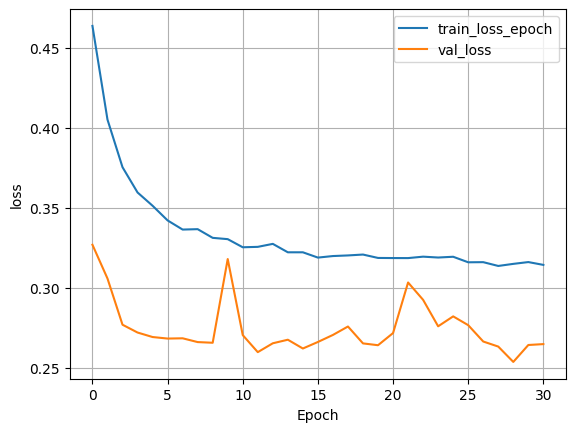

In [150]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.test_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

test_acc: 0.6729172468185425
test_f1: 0.6729172468185425
test_precision: 0.6729172468185425
test_recall: 0.6729172468185425
test_confusion_m: 
tensor([[1699,  441,  676,  424],
        [  17, 1312,   16,   26],
        [  18,    8, 1111,  625],
        [  10,    8,   16,  579]])


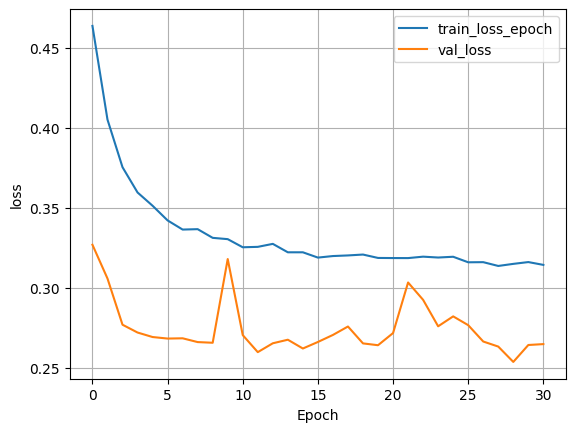

In [34]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.val_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

In [77]:
# t_dl_l = list(data_manager.train_dataloader())

tensor(0.7148, device='cuda:0')

In [51]:
print(torch.concat([torch.argmax(y1_pred[0], dim=1)[:,None], torch.argmax(y1.to(device),dim=1)[:,None]], dim=1))

tensor([[2, 2],
        [2, 2],
        [0, 2],
        [0, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [0, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [3, 2],
        [2, 2],
        [2, 2],
        [0, 2],
        [0, 2],
        [2, 2],
        [2, 2],
        [3, 2],
        [3, 2],
        [3, 2],
        [3, 2],
        [2, 2],
        [3, 2],
        [3, 2],
        [0, 2],
        [0, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [2, 2],
        [0, 2],
        [3, 2],
        [3, 2],
        [2, 2],
        [2, 2],
        [3, 2],
        [2, 2],
        [0, 2],
        [3, 2],
        [3, 2],
        [3, 2],
        [2, 2],
        [3, 2],
        [0, 2],
        [2, 2],
        [0, 2],
        [0, 2],
        

test_acc: 0.6320773363113403
test_f1: 0.6320773363113403
test_precision: 0.6320773363113403
test_recall: 0.6320773363113403
test_confusion_m: 
tensor([[27739,  8801, 11597,  9042],
        [  179, 19189,   332,   429],
        [  223,   121, 15893, 10335],
        [   79,    75,   324,  8538]])


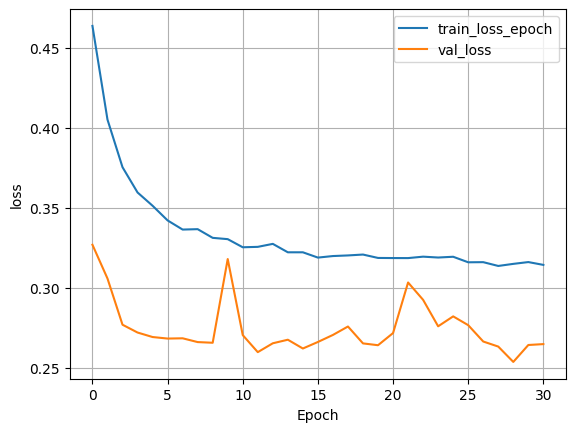

In [35]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.train_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

In [ ]:
# list(t_dataloader)[76]

NameError: name 't_dataloader' is not defined

In [ ]:
 for k in model_manager.trainer.model.model.x_batches_cpu:
     print(k, model_manager.trainer.model.model.x_batches_cpu[k].unique(return_counts=True)[1])

dep tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 

In [ ]:
print(model_manager.trainer.model.model.x_batches['tag'].to('cpu'))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
model_manager.trainer.model.loss_func.loss_logger

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
model_manager.torch_model = model_manager.torch_model.to('cuda')
save_evaluation(model_manager, data_manager.test_dataloader(), f'{k}',True, True, True, True, True, True, True, True)

In [ ]:
# lightning_model = HeteroBinaryLightningModel.load_from_checkpoint(r'C:\Users\fardin\Projects\ColorIntelligence\logs\hetero_model_5\version_0\checkpoints\epoch=7-step=2056.ckpt', model=)

# callbacks = [
#     ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True),
#     EarlyStopping(patience=50, mode='max', monitor='val_acc')
# ]
lightning_model = MultiClassLightningModel(graph_embedding, 4,
                                 torch.optim.Adam(graph_embedding.parameters(), lr=0.004, weight_decay=0.001),
                                       loss_func=torch.nn.CrossEntropyLoss(),
                                       lr=0.004,
                                       batch_size=batch_size,
                                       user_lr_scheduler=True,
                                       min_lr=0.00005
                                       ).to(device)
model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_6', model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\hetero_model_3',device=device, num_train_epoch=200)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# model_manager.tune(data_manager=data_manager, min_lr=1e-7, max_lr = 1e-2)

In [ ]:
model_manager.fit(datamodule=data_manager)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb



  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding4 | 3.8 M 
1 | loss_func | CrossEntropyLoss          | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
3.8 M     Trainable params
22        Non-trainable params
3.8 M     Total params
15.279    Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\dat

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

def evaluate(eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        model_manager.lightning_model.eval()
        for X, y in eval_dataloader:
            print(f"ii: {X.edge_index_dict[('word', 'word_sentiment', 'sentiment')]}")
            y_p, _ = model_manager.torch_model(X.to(device))
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(f"ii: {y_true.shape} : {y_pred.shape}")
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        if(give_hinge_loss):
            print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')

In [ ]:
X3, y3 = next(iter(data_manager.test_dataloader()))

In [ ]:
evaluate(data_manager.test_dataloader())

In [ ]:
model_manager.trainer.save_checkpoint(r'C:\Users\fardin\Desktop\Learning Parts 2\part1\deep_graph_embedding_1.ckpt')

In [ ]:
custom_model = HeteroBinaryLightningModel.load_from_checkpoint(r'C:\Users\fardin\Desktop\Learning Parts 2\part1\deep_graph_embedding_1.ckpt', model=graph_embedding)

In [ ]:
test_dataloader = data_manager.test_dataloader()
x_t, y_t = next(iter(test_dataloader))
len(x_t)